<a href="https://colab.research.google.com/github/TemmytheDA/Iris-Classification-Using-Pre-trained-Models/blob/main/Iris%20Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# import required libraries and modules
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler
from torch.optim.lr_scheduler import _LRScheduler
import torch.utils.data as data
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.models as models
from sklearn import decomposition
from sklearn import manifold
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from tqdm.notebook import tqdm, trange
import matplotlib.pyplot as plt
import numpy as np
import copy
from collections import namedtuple
import os
import random
import shutil
import time
import collections
import math
import pandas as pd
import copy

In [ ]:
# set the seed so the work is reproducible
SEED = 1234
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

In [ ]:
# mount google drive
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
# Unpack the dataset zip file
shutil.unpack_archive("/content/drive/MyDrive/archive.zip", "/content/Datasets/")

In [ ]:
# set the batch size
batch_size = 32

# IMAGE PRE-PROCESSING:
transform_train = transforms.Compose([
    # resize the image to create a new 224 x 224 image
    transforms.Resize((224,224)),
    # convert to a PyTorch tensor
    transforms.ToTensor(),
    # normalise each channel of the image
    transforms.Normalize([0.3590, 0.2300, 0.1499], [0.2296, 0.1540, 0.1038])])

transform_test = transforms.Compose([
    # resize the image to create a new 224 x 224 image
    transforms.Resize((224,224)),
    # convert to a PyTorch tensor
    transforms.ToTensor(),
    # normalise each channel of the image
    transforms.Normalize([0.3590, 0.2300, 0.1499], [0.2296, 0.1540, 0.1038])])

In [ ]:
# create PyTorch datasets for training, validation, and testing
data_dir = '/content/Datasets/release'

train_ds = datasets.ImageFolder(
    os.path.join(data_dir, 'train'),
    transform=transform_train)

valid_ds = datasets.ImageFolder(
    os.path.join(data_dir, 'validation'),
    transform=transform_test)

test_ds = datasets.ImageFolder(
    os.path.join(data_dir, 'test'),
    transform=transform_test)

In [ ]:
# create data loaders for the training, validation, and testing datasets
train_iter = torch.utils.data.DataLoader(train_ds, batch_size, shuffle=True, drop_last=True)

valid_iter = torch.utils.data.DataLoader(valid_ds, batch_size, shuffle=False, drop_last=True)

test_iter = torch.utils.data.DataLoader(test_ds, batch_size, shuffle=False, drop_last=False)

In [ ]:
# calculate the means and standard deviations for each of the three channels - used for image normalisation
means = torch.zeros(3)
stds = torch.zeros(3)

for img, label in train_ds:
    means += torch.mean(img, dim = (1,2))
    stds += torch.std(img, dim = (1,2))

means /= len(train_ds)
stds /= len(train_ds)

print(f'Calculated means: {means}')
print(f'Calculated stds: {stds}')

Calculated means: tensor([0.3590, 0.2300, 0.1499])
Calculated stds: tensor([0.2296, 0.1540, 0.1038])


In [ ]:
# create two functions - one for normalising the images and the other one for the plotting of the images
def normalize_image(image):
    image_min = image.min()
    image_max = image.max()
    image.clamp_(min = image_min, max = image_max)
    image.add_(-image_min).div_(image_max - image_min + 1e-5)
    return image

def plot_images(images, labels, classes, normalize = True):

    n_images = len(images)

    rows = int(np.sqrt(n_images))
    cols = int(np.sqrt(n_images))

    fig = plt.figure(figsize = (15, 15))

    for i in range(rows*cols):

        ax = fig.add_subplot(rows, cols, i+1)

        image = images[i]

        if normalize:
            image = normalize_image(image)

        ax.imshow(image.permute(1, 2, 0).cpu().numpy())
        label = classes[labels[i]]
        ax.set_title(label)
        ax.axis('off')

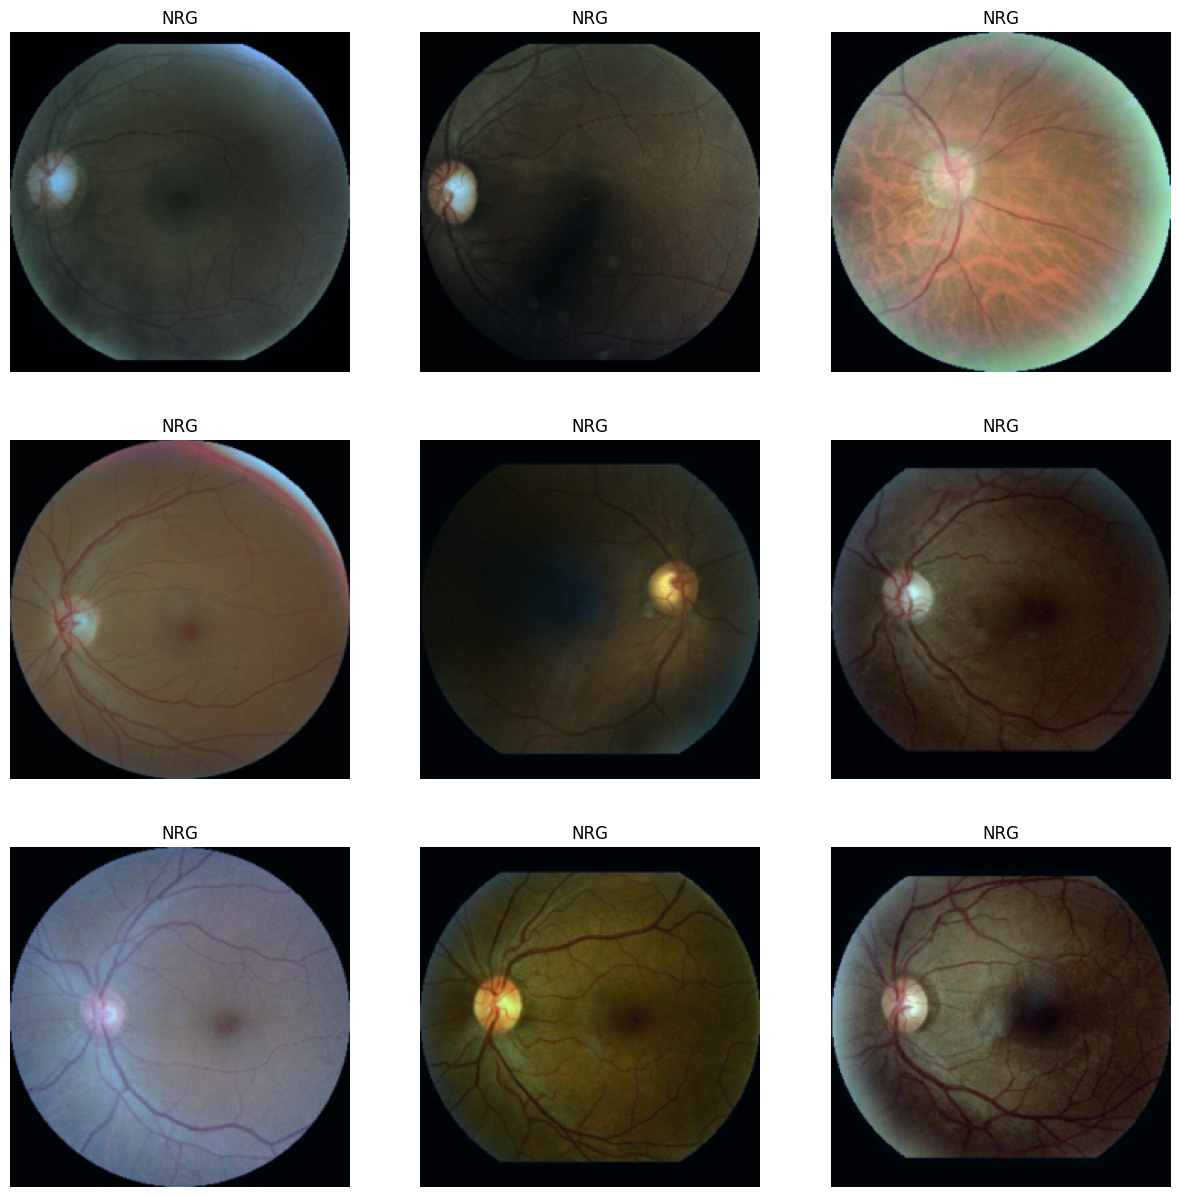

In [ ]:
# plot some images from the training dataset (use the plot_images function)
N_IMAGES = 10

images, labels = zip(*[(image, label) for image, label in
                           [train_ds[i] for i in range(N_IMAGES)]])

classes = train_ds.classes

plot_images(images, labels, classes)

In [ ]:
# define a VGG neural network architecture with layer configurations
# create a function to create the convolutional layers based on the given configuration
class VGG(nn.Module):
    def __init__(self, features, output_dim):
        super().__init__()

        self.features = features

        self.avgpool = nn.AdaptiveAvgPool2d(7)

        self.classifier = nn.Sequential(
            nn.Linear(512 * 7 * 7, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(4096, output_dim),
        )

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        h = x.view(x.shape[0], -1)
        x = self.classifier(h)
        return x, h

vgg11_config = [64, 'M', 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M']

vgg13_config = [64, 64, 'M', 128, 128, 'M', 256, 256, 'M', 512, 512, 'M', 512,
                512, 'M']

vgg16_config = [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512,
                'M', 512, 512, 512, 'M']

vgg19_config = [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 256, 'M', 512, 512,
                512, 512, 'M', 512, 512, 512, 512, 'M']

def get_vgg_layers(config, batch_norm):

    layers = []
    in_channels = 3

    for c in config:
        assert c == 'M' or isinstance(c, int)
        if c == 'M':
            layers += [nn.MaxPool2d(kernel_size=2)]
        else:
            conv2d = nn.Conv2d(in_channels, c, kernel_size=3, padding=1)
            if batch_norm:
                layers += [conv2d, nn.BatchNorm2d(c), nn.ReLU(inplace=True)]
            else:
                layers += [conv2d, nn.ReLU(inplace=True)]
            in_channels = c

    return nn.Sequential(*layers)

In [ ]:
# create a VGG16 model
vgg16_layers = get_vgg_layers(vgg16_config, batch_norm=True)
print(vgg16_layers)

OUTPUT_DIM = 2

model = VGG(vgg16_layers, OUTPUT_DIM)
print(model)
pretrained_model = models.vgg13_bn(pretrained=True)
print(pretrained_model)
IN_FEATURES = pretrained_model.classifier[-1].in_features

final_fc = nn.Linear(IN_FEATURES, OUTPUT_DIM)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (5): ReLU(inplace=True)
  (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (9): ReLU(inplace=True)
  (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (12): ReLU(inplace=True)
  (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (14): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 

In [ ]:
# function that counts the number of trainable parameters
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 134,277,186 trainable parameters


In [ ]:
# define the hyperparameters of the model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
criterion = nn.CrossEntropyLoss()

model = model.to(device)
criterion = criterion.to(device)

FOUND_LR = 5e-4

params = [
          {'params': model.features.parameters(), 'lr': FOUND_LR / 10},
          {'params': model.classifier.parameters()}
         ]

optimizer = optim.Adam(params, lr=FOUND_LR)

In [ ]:
# create a function for the computation of accuracy
def calculate_accuracy(y_pred, y):
    top_pred = y_pred.argmax(1, keepdim=True)
    correct = top_pred.eq(y.view_as(top_pred)).sum()
    acc = correct.float() / y.shape[0]
    return acc

In [ ]:
# create functions for the training of the model and the evaluation of the model
def train(model, iterator, optimizer, criterion, device):

    epoch_loss = 0
    epoch_acc = 0

    model.train()

    for (x, y) in tqdm(iterator, desc="Training", leave=False):

        x = x.to(device)
        y = y.to(device)

        optimizer.zero_grad()

        y_pred, _ = model(x)

        loss = criterion(y_pred, y)

        acc = calculate_accuracy(y_pred, y)

        loss.backward()

        optimizer.step()

        epoch_loss += loss.item()
        epoch_acc += acc.item()

    return epoch_loss / len(iterator), epoch_acc / len(iterator)

def evaluate(model, iterator, criterion, device):

    epoch_loss = 0
    epoch_acc = 0

    model.eval()

    with torch.no_grad():

        for (x, y) in tqdm(iterator, desc="Evaluating", leave=False):

            x = x.to(device)
            y = y.to(device)

            y_pred, _ = model(x)

            loss = criterion(y_pred, y)

            acc = calculate_accuracy(y_pred, y)

            epoch_loss += loss.item()
            epoch_acc += acc.item()

    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [ ]:
# create a function that calculates the elapsed time between a start time and an end time
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [ ]:
# create a function that returns the images, labels, and predicted probabilities
def get_predictions(model, iterator):

    model.eval()

    images = []
    labels = []
    probs = []

    with torch.no_grad():

        for (x, y) in tqdm(iterator):

            x = x.to(device)

            y_pred, _ = model(x)

            y_prob = F.softmax(y_pred, dim=-1)

            images.append(x.cpu())
            labels.append(y.cpu())
            probs.append(y_prob.cpu())

    images = torch.cat(images, dim=0)
    labels = torch.cat(labels, dim=0)
    probs = torch.cat(probs, dim=0)

    return images, labels, probs

In [ ]:
# train the VGG16 model for 50 epochs
EPOCHS = 50

best_valid_loss = float('inf')

for epoch in trange(EPOCHS, desc="Epochs"):

    start_time = time.monotonic()

    train_loss, train_acc = train(model, train_iter, optimizer, criterion, device)
    valid_loss, valid_acc = evaluate(model, valid_iter, criterion, device)

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'best-model.pt')

    end_time = time.monotonic()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')

Epochs:   0%|          | 0/50 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 01 | Epoch Time: 1m 50s
	Train Loss: 1.682 | Train Acc: 50.84%
	 Val. Loss: 0.715 |  Val. Acc: 55.47%


Training:   0%|          | 0/156 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 02 | Epoch Time: 1m 50s
	Train Loss: 0.739 | Train Acc: 51.88%
	 Val. Loss: 0.691 |  Val. Acc: 59.57%


Training:   0%|          | 0/156 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 03 | Epoch Time: 1m 50s
	Train Loss: 0.711 | Train Acc: 53.39%
	 Val. Loss: 0.687 |  Val. Acc: 57.03%


Training:   0%|          | 0/156 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 04 | Epoch Time: 1m 50s
	Train Loss: 0.684 | Train Acc: 57.41%
	 Val. Loss: 0.663 |  Val. Acc: 62.30%


Training:   0%|          | 0/156 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 05 | Epoch Time: 1m 50s
	Train Loss: 0.668 | Train Acc: 59.03%
	 Val. Loss: 0.644 |  Val. Acc: 63.48%


Training:   0%|          | 0/156 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 06 | Epoch Time: 1m 47s
	Train Loss: 0.665 | Train Acc: 60.96%
	 Val. Loss: 0.652 |  Val. Acc: 64.65%


Training:   0%|          | 0/156 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 07 | Epoch Time: 1m 50s
	Train Loss: 0.632 | Train Acc: 65.36%
	 Val. Loss: 0.594 |  Val. Acc: 68.95%


Training:   0%|          | 0/156 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 08 | Epoch Time: 1m 47s
	Train Loss: 0.615 | Train Acc: 67.47%
	 Val. Loss: 0.602 |  Val. Acc: 65.82%


Training:   0%|          | 0/156 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 09 | Epoch Time: 1m 50s
	Train Loss: 0.587 | Train Acc: 70.81%
	 Val. Loss: 0.578 |  Val. Acc: 71.48%


Training:   0%|          | 0/156 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 10 | Epoch Time: 1m 50s
	Train Loss: 0.558 | Train Acc: 72.42%
	 Val. Loss: 0.555 |  Val. Acc: 73.05%


Training:   0%|          | 0/156 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 11 | Epoch Time: 1m 50s
	Train Loss: 0.549 | Train Acc: 74.16%
	 Val. Loss: 0.534 |  Val. Acc: 73.83%


Training:   0%|          | 0/156 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 12 | Epoch Time: 1m 50s
	Train Loss: 0.519 | Train Acc: 76.00%
	 Val. Loss: 0.524 |  Val. Acc: 74.80%


Training:   0%|          | 0/156 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 13 | Epoch Time: 1m 48s
	Train Loss: 0.524 | Train Acc: 75.30%
	 Val. Loss: 0.585 |  Val. Acc: 72.27%


Training:   0%|          | 0/156 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 14 | Epoch Time: 1m 50s
	Train Loss: 0.517 | Train Acc: 76.22%
	 Val. Loss: 0.517 |  Val. Acc: 75.00%


Training:   0%|          | 0/156 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 15 | Epoch Time: 1m 50s
	Train Loss: 0.489 | Train Acc: 77.92%
	 Val. Loss: 0.494 |  Val. Acc: 75.78%


Training:   0%|          | 0/156 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 16 | Epoch Time: 1m 50s
	Train Loss: 0.495 | Train Acc: 77.58%
	 Val. Loss: 0.476 |  Val. Acc: 77.54%


Training:   0%|          | 0/156 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 17 | Epoch Time: 1m 48s
	Train Loss: 0.453 | Train Acc: 80.37%
	 Val. Loss: 0.477 |  Val. Acc: 80.08%


Training:   0%|          | 0/156 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 18 | Epoch Time: 1m 48s
	Train Loss: 0.456 | Train Acc: 80.43%
	 Val. Loss: 0.574 |  Val. Acc: 73.44%


Training:   0%|          | 0/156 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 19 | Epoch Time: 1m 50s
	Train Loss: 0.426 | Train Acc: 81.67%
	 Val. Loss: 0.458 |  Val. Acc: 80.47%


Training:   0%|          | 0/156 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 20 | Epoch Time: 1m 48s
	Train Loss: 0.397 | Train Acc: 83.17%
	 Val. Loss: 0.646 |  Val. Acc: 75.39%


Training:   0%|          | 0/156 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 21 | Epoch Time: 1m 51s
	Train Loss: 0.409 | Train Acc: 83.67%
	 Val. Loss: 0.411 |  Val. Acc: 79.88%


Training:   0%|          | 0/156 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 22 | Epoch Time: 1m 51s
	Train Loss: 0.370 | Train Acc: 84.92%
	 Val. Loss: 0.354 |  Val. Acc: 85.55%


Training:   0%|          | 0/156 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 23 | Epoch Time: 1m 48s
	Train Loss: 0.355 | Train Acc: 86.08%
	 Val. Loss: 0.407 |  Val. Acc: 80.08%


Training:   0%|          | 0/156 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 24 | Epoch Time: 1m 48s
	Train Loss: 0.350 | Train Acc: 85.88%
	 Val. Loss: 0.389 |  Val. Acc: 83.01%


Training:   0%|          | 0/156 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 25 | Epoch Time: 1m 48s
	Train Loss: 0.324 | Train Acc: 87.32%
	 Val. Loss: 0.411 |  Val. Acc: 85.16%


Training:   0%|          | 0/156 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 26 | Epoch Time: 1m 48s
	Train Loss: 0.331 | Train Acc: 86.72%
	 Val. Loss: 0.415 |  Val. Acc: 80.66%


Training:   0%|          | 0/156 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 27 | Epoch Time: 1m 48s
	Train Loss: 0.294 | Train Acc: 89.24%
	 Val. Loss: 0.360 |  Val. Acc: 85.74%


Training:   0%|          | 0/156 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 28 | Epoch Time: 1m 48s
	Train Loss: 0.270 | Train Acc: 90.71%
	 Val. Loss: 0.358 |  Val. Acc: 85.74%


Training:   0%|          | 0/156 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 29 | Epoch Time: 1m 49s
	Train Loss: 0.272 | Train Acc: 89.54%
	 Val. Loss: 0.373 |  Val. Acc: 83.40%


Training:   0%|          | 0/156 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 30 | Epoch Time: 1m 49s
	Train Loss: 0.281 | Train Acc: 89.94%
	 Val. Loss: 0.368 |  Val. Acc: 83.20%


Training:   0%|          | 0/156 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 31 | Epoch Time: 1m 48s
	Train Loss: 0.301 | Train Acc: 88.70%
	 Val. Loss: 0.376 |  Val. Acc: 86.33%


Training:   0%|          | 0/156 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 32 | Epoch Time: 1m 51s
	Train Loss: 0.265 | Train Acc: 90.42%
	 Val. Loss: 0.331 |  Val. Acc: 85.94%


Training:   0%|          | 0/156 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 33 | Epoch Time: 1m 48s
	Train Loss: 0.260 | Train Acc: 90.16%
	 Val. Loss: 0.487 |  Val. Acc: 83.79%


Training:   0%|          | 0/156 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 34 | Epoch Time: 1m 48s
	Train Loss: 0.239 | Train Acc: 91.15%
	 Val. Loss: 0.364 |  Val. Acc: 82.81%


Training:   0%|          | 0/156 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 35 | Epoch Time: 1m 48s
	Train Loss: 0.281 | Train Acc: 89.22%
	 Val. Loss: 0.355 |  Val. Acc: 87.11%


Training:   0%|          | 0/156 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 36 | Epoch Time: 1m 49s
	Train Loss: 0.246 | Train Acc: 90.50%
	 Val. Loss: 0.367 |  Val. Acc: 86.13%


Training:   0%|          | 0/156 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 37 | Epoch Time: 1m 48s
	Train Loss: 0.179 | Train Acc: 93.69%
	 Val. Loss: 0.481 |  Val. Acc: 86.33%


Training:   0%|          | 0/156 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 38 | Epoch Time: 1m 48s
	Train Loss: 0.198 | Train Acc: 92.69%
	 Val. Loss: 0.433 |  Val. Acc: 83.98%


Training:   0%|          | 0/156 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 39 | Epoch Time: 1m 48s
	Train Loss: 0.187 | Train Acc: 93.59%
	 Val. Loss: 0.364 |  Val. Acc: 87.89%


Training:   0%|          | 0/156 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 40 | Epoch Time: 1m 48s
	Train Loss: 0.153 | Train Acc: 94.77%
	 Val. Loss: 0.420 |  Val. Acc: 87.11%


Training:   0%|          | 0/156 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 41 | Epoch Time: 1m 48s
	Train Loss: 0.153 | Train Acc: 95.39%
	 Val. Loss: 0.530 |  Val. Acc: 86.52%


Training:   0%|          | 0/156 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 42 | Epoch Time: 1m 48s
	Train Loss: 0.248 | Train Acc: 91.43%
	 Val. Loss: 0.445 |  Val. Acc: 83.40%


Training:   0%|          | 0/156 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 43 | Epoch Time: 1m 48s
	Train Loss: 0.191 | Train Acc: 93.17%
	 Val. Loss: 0.360 |  Val. Acc: 88.87%


Training:   0%|          | 0/156 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 44 | Epoch Time: 1m 48s
	Train Loss: 0.185 | Train Acc: 93.41%
	 Val. Loss: 0.365 |  Val. Acc: 87.70%


Training:   0%|          | 0/156 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 45 | Epoch Time: 1m 48s
	Train Loss: 0.116 | Train Acc: 96.31%
	 Val. Loss: 0.555 |  Val. Acc: 86.13%


Training:   0%|          | 0/156 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 46 | Epoch Time: 1m 48s
	Train Loss: 0.207 | Train Acc: 92.63%
	 Val. Loss: 0.483 |  Val. Acc: 85.55%


Training:   0%|          | 0/156 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 47 | Epoch Time: 1m 48s
	Train Loss: 0.135 | Train Acc: 95.65%
	 Val. Loss: 0.668 |  Val. Acc: 86.52%


Training:   0%|          | 0/156 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 48 | Epoch Time: 1m 48s
	Train Loss: 0.157 | Train Acc: 94.85%
	 Val. Loss: 0.422 |  Val. Acc: 87.11%


Training:   0%|          | 0/156 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 49 | Epoch Time: 1m 48s
	Train Loss: 0.137 | Train Acc: 95.93%
	 Val. Loss: 0.482 |  Val. Acc: 87.11%


Training:   0%|          | 0/156 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 50 | Epoch Time: 1m 48s
	Train Loss: 0.136 | Train Acc: 95.37%
	 Val. Loss: 0.601 |  Val. Acc: 86.52%


In [ ]:
# load the best model
model.load_state_dict(torch.load('best-model.pt'))

<All keys matched successfully>

In [ ]:
images, labels, probs = get_predictions(model, test_iter)

  0%|          | 0/32 [00:00<?, ?it/s]

In [ ]:
# get the ground truth data and drop the 'id' column
test = pd.read_csv('/content/drive/My Drive/Test_GroundTruth (1).csv')
y_test = np.array(test.drop(['id'], axis=1))

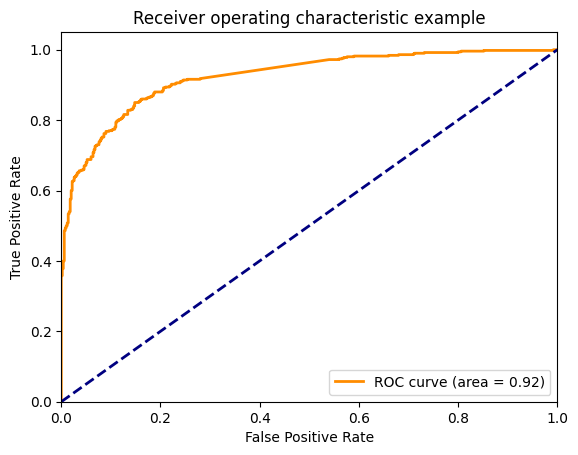

<ipython-input-72-84e4679372e9>:45: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  mean_tpr += interp(all_fpr, fpr[i], tpr[i])


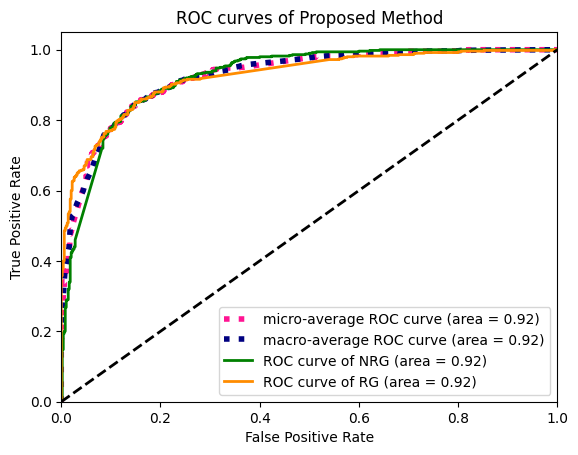

In [ ]:
# plot the ROC curve and calculate the AUC score
from itertools import cycle
from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from scipy import interp
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_recall_fscore_support

n_classes=2

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), probs.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

plt.figure()
lw = 2
plt.plot(fpr[1], tpr[1], color='darkorange',lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[1])
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure()
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

plt.plot(fpr[0], tpr[0], color='green', lw=lw,
         label='ROC curve of NRG (area = {1:0.2f})'
         ''.format(0, roc_auc[0]))

plt.plot(fpr[1], tpr[1], color='darkorange', lw=lw,
         label='ROC curve of RG (area = {1:0.2f})'
         ''.format(1, roc_auc[1]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curves of Proposed Method')
plt.legend(loc="lower right")
plt.show()

[[428  72]
 [ 84 416]]
[0 1]
[500 500]
[[500. 500.]
 [500. 500.]]


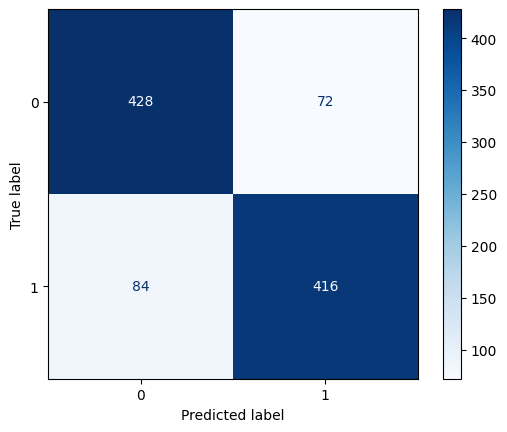

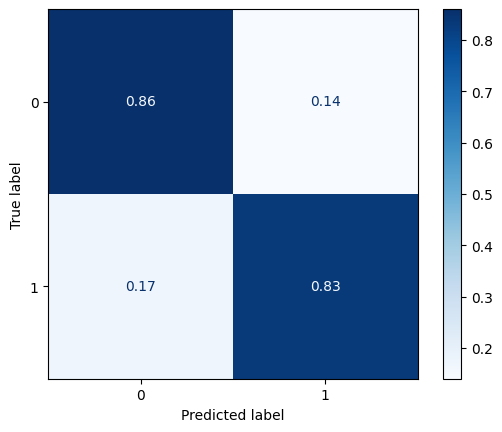

In [ ]:
# plot the standard and normalised confusion matrices
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels
from matplotlib.colors import Normalize
from sklearn.metrics import ConfusionMatrixDisplay

pred_class = np.argmax(probs,axis=1)
true_class = np.argmax(y_test, axis=1)

cm=confusion_matrix(true_class, pred_class)
class_names = unique_labels(true_class, pred_class)
print(cm)
print(class_names)

disp = ConfusionMatrixDisplay(cm, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues)

C = cm
divisor = np.zeros((2,2))
divisor[0][:] = 500
divisor[1][:] = 500
cm_normalised=np.divide(cm, divisor)
print(np.transpose(C.sum(axis=1)))
print(divisor)
cm_normalised = np.round(cm_normalised, 2)
disp = ConfusionMatrixDisplay(cm_normalised, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues, values_format='')

In [ ]:
# define the ResNet architecture for different configurations
class ResNet(nn.Module):
    def __init__(self, config, output_dim):
        super().__init__()

        block, n_blocks, channels = config
        self.in_channels = channels[0]

        assert len(n_blocks) == len(channels) == 4

        self.conv1 = nn.Conv2d(3, self.in_channels, kernel_size = 7, stride = 2, padding = 3, bias = False)
        self.bn1 = nn.BatchNorm2d(self.in_channels)
        self.relu = nn.ReLU(inplace = True)
        self.maxpool = nn.MaxPool2d(kernel_size = 3, stride = 2, padding = 1)

        self.layer1 = self.get_resnet_layer(block, n_blocks[0], channels[0])
        self.layer2 = self.get_resnet_layer(block, n_blocks[1], channels[1], stride = 2)
        self.layer3 = self.get_resnet_layer(block, n_blocks[2], channels[2], stride = 2)
        self.layer4 = self.get_resnet_layer(block, n_blocks[3], channels[3], stride = 2)

        self.avgpool = nn.AdaptiveAvgPool2d((1,1))
        self.fc = nn.Linear(self.in_channels, output_dim)

    def get_resnet_layer(self, block, n_blocks, channels, stride = 1):

        layers = []

        if self.in_channels != block.expansion * channels:
            downsample = True
        else:
            downsample = False

        layers.append(block(self.in_channels, channels, stride, downsample))

        for i in range(1, n_blocks):
            layers.append(block(block.expansion * channels, channels))

        self.in_channels = block.expansion * channels

        return nn.Sequential(*layers)

    def forward(self, x):

        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        h = x.view(x.shape[0], -1)
        x = self.fc(h)

        return x, h

class BasicBlock(nn.Module):

    expansion = 1

    def __init__(self, in_channels, out_channels, stride = 1, downsample = False):
        super().__init__()

        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size = 3,
                               stride = stride, padding = 1, bias = False)
        self.bn1 = nn.BatchNorm2d(out_channels)

        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size = 3,
                               stride = 1, padding = 1, bias = False)
        self.bn2 = nn.BatchNorm2d(out_channels)

        self.relu = nn.ReLU(inplace = True)

        if downsample:
            conv = nn.Conv2d(in_channels, out_channels, kernel_size = 1,
                             stride = stride, bias = False)
            bn = nn.BatchNorm2d(out_channels)
            downsample = nn.Sequential(conv, bn)
        else:
            downsample = None

        self.downsample = downsample

    def forward(self, x):

        i = x

        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)

        x = self.conv2(x)
        x = self.bn2(x)

        if self.downsample is not None:
            i = self.downsample(i)

        x += i
        x = self.relu(x)

        return x

ResNetConfig = namedtuple('ResNetConfig', ['block', 'n_blocks', 'channels'])
resnet18_config = ResNetConfig(block = BasicBlock,
                               n_blocks = [2,2,2,2],
                               channels = [64, 128, 256, 512])

resnet34_config = ResNetConfig(block = BasicBlock,
                               n_blocks = [3,4,6,3],
                               channels = [64, 128, 256, 512])

class Bottleneck(nn.Module):

    expansion = 4

    def __init__(self, in_channels, out_channels, stride = 1, downsample = False):
        super().__init__()

        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size = 1,
                               stride = 1, bias = False)
        self.bn1 = nn.BatchNorm2d(out_channels)

        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size = 3,
                               stride = stride, padding = 1, bias = False)
        self.bn2 = nn.BatchNorm2d(out_channels)

        self.conv3 = nn.Conv2d(out_channels, self.expansion * out_channels, kernel_size = 1,
                               stride = 1, bias = False)
        self.bn3 = nn.BatchNorm2d(self.expansion * out_channels)

        self.relu = nn.ReLU(inplace = True)

        if downsample:
            conv = nn.Conv2d(in_channels, self.expansion * out_channels, kernel_size = 1,
                             stride = stride, bias = False)
            bn = nn.BatchNorm2d(self.expansion * out_channels)
            downsample = nn.Sequential(conv, bn)
        else:
            downsample = None

        self.downsample = downsample

    def forward(self, x):

        i = x

        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)

        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)

        x = self.conv3(x)
        x = self.bn3(x)

        if self.downsample is not None:
            i = self.downsample(i)

        x += i
        x = self.relu(x)

        return x

resnet50_config = ResNetConfig(block = Bottleneck,
                               n_blocks = [3, 4, 6, 3],
                               channels = [64, 128, 256, 512])

resnet101_config = ResNetConfig(block = Bottleneck,
                                n_blocks = [3, 4, 23, 3],
                                channels = [64, 128, 256, 512])

resnet152_config = ResNetConfig(block = Bottleneck,
                                n_blocks = [3, 8, 36, 3],
                                channels = [64, 128, 256, 512])

In [ ]:
# initialise the ResNet18 model
pretrained_model = models.resnet18(pretrained = True)
IN_FEATURES = pretrained_model.fc.in_features
OUTPUT_DIM = len(train_ds.classes)

fc = nn.Linear(IN_FEATURES, OUTPUT_DIM)
pretrained_model.fc = fc
model = ResNet(resnet18_config, OUTPUT_DIM)
model.load_state_dict(pretrained_model.state_dict())

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 94.8MB/s]


<All keys matched successfully>

In [ ]:
# function that counts the number of trainable parameters
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 11,177,538 trainable parameters


In [ ]:
# specify the hyperparameters for ResNet18
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

criterion = nn.CrossEntropyLoss()

model = model.to(device)
criterion = criterion.to(device)

FOUND_LR = 1e-3

params = [
          {'params': model.conv1.parameters(), 'lr': FOUND_LR / 10},
          {'params': model.bn1.parameters(), 'lr': FOUND_LR / 10},
          {'params': model.layer1.parameters(), 'lr': FOUND_LR / 8},
          {'params': model.layer2.parameters(), 'lr': FOUND_LR / 6},
          {'params': model.layer3.parameters(), 'lr': FOUND_LR / 4},
          {'params': model.layer4.parameters(), 'lr': FOUND_LR / 2},
          {'params': model.fc.parameters()}
         ]

optimizer = optim.Adam(params, lr = FOUND_LR)


In [ ]:
# specify the number of epochs to be 15
EPOCHS = 15
STEPS_PER_EPOCH = len(train_iter)
TOTAL_STEPS = EPOCHS * STEPS_PER_EPOCH

MAX_LRS = [p['lr'] for p in optimizer.param_groups]

scheduler = lr_scheduler.OneCycleLR(optimizer,
                                    max_lr = MAX_LRS,
                                    total_steps = TOTAL_STEPS)


In [ ]:
# create a function that calculates the top-k accuracy of given predicted values and true labels
def calculate_topk_accuracy(y_pred, y, k = 2):
    with torch.no_grad():
        batch_size = y.shape[0]
        _, top_pred = y_pred.topk(k, 1)
        top_pred = top_pred.t()
        correct = top_pred.eq(y.view(1, -1).expand_as(top_pred))
        correct_1 = correct[:1].reshape(-1).float().sum(0, keepdim = True)
        correct_k = correct[:k].reshape(-1).float().sum(0, keepdim = True)
        acc_1 = correct_1 / batch_size
        acc_k = correct_k / batch_size
    return acc_1, acc_k


In [ ]:
# define a function for model training
def train(model, iterator, optimizer, criterion, scheduler, device):

    epoch_loss = 0
    epoch_acc_1 = 0
    epoch_acc_5 = 0

    model.train()

    for (x, y) in iterator:

        x = x.to(device)
        y = y.to(device)

        optimizer.zero_grad()

        y_pred, _ = model(x)

        loss = criterion(y_pred, y)

        acc_1, acc_5 = calculate_topk_accuracy(y_pred, y)

        loss.backward()

        optimizer.step()

        scheduler.step()

        epoch_loss += loss.item()
        epoch_acc_1 += acc_1.item()
        epoch_acc_5 += acc_5.item()

    epoch_loss /= len(iterator)
    epoch_acc_1 /= len(iterator)
    epoch_acc_5 /= len(iterator)

    return epoch_loss, epoch_acc_1, epoch_acc_5

In [ ]:
# define a function for model evaluation
def evaluate(model, iterator, criterion, device):

    epoch_loss = 0
    epoch_acc_1 = 0
    epoch_acc_5 = 0

    model.eval()

    with torch.no_grad():

        for (x, y) in iterator:

            x = x.to(device)
            y = y.to(device)

            y_pred, _ = model(x)

            loss = criterion(y_pred, y)

            acc_1, acc_5 = calculate_topk_accuracy(y_pred, y)

            epoch_loss += loss.item()
            epoch_acc_1 += acc_1.item()
            epoch_acc_5 += acc_5.item()

    epoch_loss /= len(iterator)
    epoch_acc_1 /= len(iterator)
    epoch_acc_5 /= len(iterator)

    return epoch_loss, epoch_acc_1, epoch_acc_5

In [ ]:
# create a function that calculates the elapsed time between a start time and an end time
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [ ]:
# train the ResNet18 model
best_valid_loss = float('inf')

for epoch in range(EPOCHS):

    start_time = time.monotonic()

    train_loss, train_acc_1, train_acc_5 = train(model, train_iter, optimizer, criterion, scheduler, device)
    valid_loss, valid_acc_1, valid_acc_5 = evaluate(model, valid_iter, criterion, device)

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
       # print(epoch)
        torch.save(model.state_dict(), 'best-model.pt')

    end_time = time.monotonic()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc @1: {train_acc_1*100:6.2f}% | ' \
          f'Train Acc @5: {train_acc_5*100:6.2f}%')
    print(f'\tValid Loss: {valid_loss:.3f} | Valid Acc @1: {valid_acc_1*100:6.2f}% | ' \
          f'Valid Acc @5: {valid_acc_5*100:6.2f}%')

Epoch: 01 | Epoch Time: 0m 44s
	Train Loss: 0.492 | Train Acc @1:  75.10% | Train Acc @5: 100.00%
	Valid Loss: 0.449 | Valid Acc @1:  78.52% | Valid Acc @5: 100.00%
Epoch: 02 | Epoch Time: 0m 35s
	Train Loss: 0.338 | Train Acc @1:  85.76% | Train Acc @5: 100.00%
	Valid Loss: 0.434 | Valid Acc @1:  82.42% | Valid Acc @5: 100.00%
Epoch: 03 | Epoch Time: 0m 34s
	Train Loss: 0.246 | Train Acc @1:  90.54% | Train Acc @5: 100.00%
	Valid Loss: 0.404 | Valid Acc @1:  80.27% | Valid Acc @5: 100.00%
Epoch: 04 | Epoch Time: 0m 34s
	Train Loss: 0.169 | Train Acc @1:  93.57% | Train Acc @5: 100.00%
	Valid Loss: 0.424 | Valid Acc @1:  86.72% | Valid Acc @5: 100.00%
Epoch: 05 | Epoch Time: 0m 34s
	Train Loss: 0.123 | Train Acc @1:  95.53% | Train Acc @5: 100.00%
	Valid Loss: 0.848 | Valid Acc @1:  77.93% | Valid Acc @5: 100.00%
Epoch: 06 | Epoch Time: 0m 34s
	Train Loss: 0.080 | Train Acc @1:  97.08% | Train Acc @5: 100.00%
	Valid Loss: 0.437 | Valid Acc @1:  86.52% | Valid Acc @5: 100.00%
Epoch: 07 

In [ ]:
# create a function that returns the images, labels, and predicted probabilities
def get_predictions(model, iterator):

    model.eval()

    images = []
    labels = []
    probs = []

    with torch.no_grad():

        for (x, y) in iterator:

            x = x.to(device)

            y_pred, _ = model(x)

            y_prob = F.softmax(y_pred, dim = -1)
            top_pred = y_prob.argmax(1, keepdim = True)

            images.append(x.cpu())
            labels.append(y.cpu())
            probs.append(y_prob.cpu())

    images = torch.cat(images, dim = 0)
    labels = torch.cat(labels, dim = 0)
    probs = torch.cat(probs, dim = 0)

    return images, labels, probs


In [ ]:
# load the best model
model.load_state_dict(torch.load('best-model.pt'))

<All keys matched successfully>

In [ ]:
images, labels, probs = get_predictions(model, test_iter)

In [ ]:
# get the ground truth data and drop the 'id' column
test = pd.read_csv('/content/drive/My Drive/Test_GroundTruth (1).csv')
y_test = np.array(test.drop(['id'], axis=1))

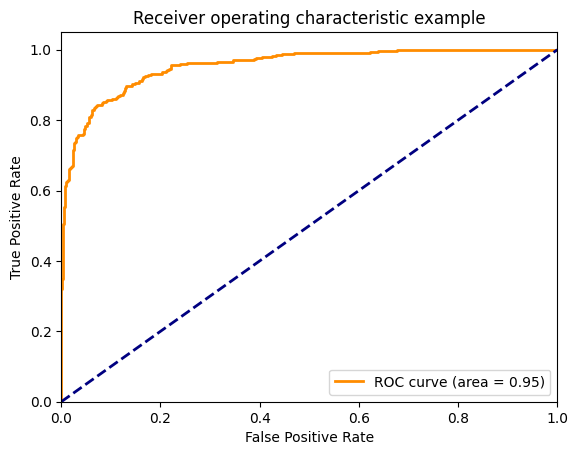

<ipython-input-22-24bb8ea9d02f>:44: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  mean_tpr += interp(all_fpr, fpr[i], tpr[i])


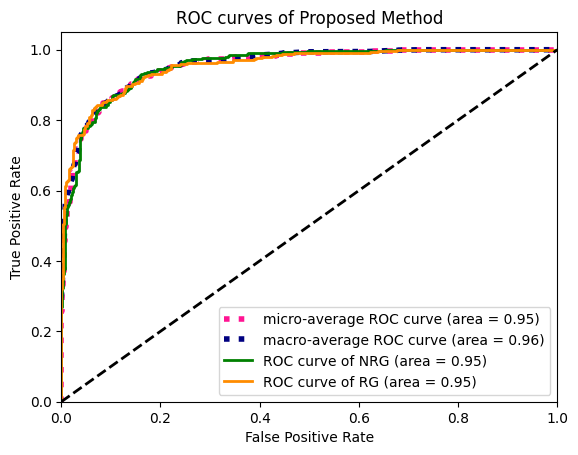

In [ ]:
# plot the ROC curve and compute the AUC score

n_classes=2

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), probs.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

plt.figure()
lw = 2
plt.plot(fpr[1], tpr[1], color='darkorange',lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[1])
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure()
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

plt.plot(fpr[0], tpr[0], color='green', lw=lw,
         label='ROC curve of NRG (area = {1:0.2f})'
         ''.format(0, roc_auc[0]))

plt.plot(fpr[1], tpr[1], color='darkorange', lw=lw,
         label='ROC curve of RG (area = {1:0.2f})'
         ''.format(1, roc_auc[1]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curves of Proposed Method')
plt.legend(loc="lower right")
plt.show()


[[452  48]
 [ 71 429]]
[0 1]
[500 500]
[[500. 500.]
 [500. 500.]]


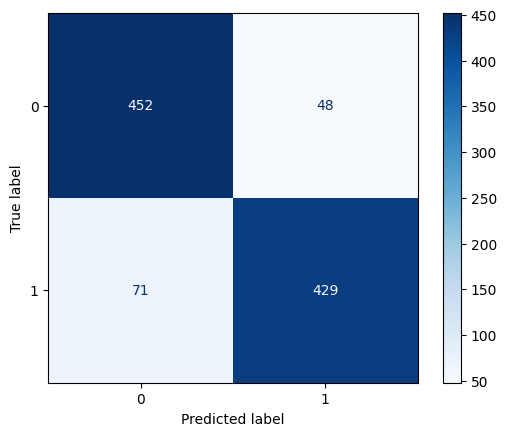

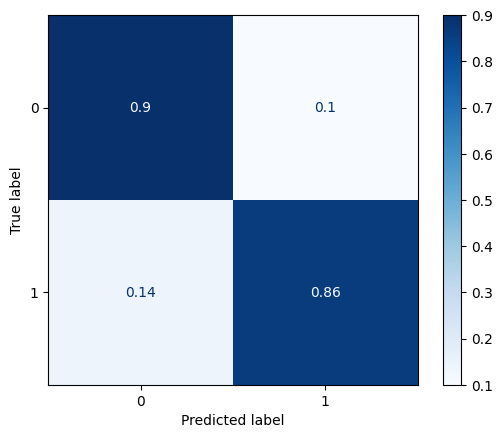

In [ ]:
# plot the standard and normalised confusion matrices

pred_class = np.argmax(probs,axis=1)
true_class = np.argmax(y_test, axis=1)

cm=confusion_matrix(true_class, pred_class)
class_names = unique_labels(true_class, pred_class)
print(cm)
print(class_names)

disp = ConfusionMatrixDisplay(cm, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues)

C = cm
divisor = np.zeros((2,2))
divisor[0][:] = 500
divisor[1][:] = 500
cm_normalised=np.divide(cm, divisor)
print(np.transpose(C.sum(axis=1)))
print(divisor)
cm_normalised = np.round(cm_normalised, 2)
disp = ConfusionMatrixDisplay(cm_normalised, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues, values_format='')
